In [452]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ironsilicate import IronSilicateEOS
from scipy import interpolate
from scipy import integrate
%matplotlib inline

In [453]:
kepids, koi, per = np.loadtxt("USP_planet_info.txt")
rad_arrays= np.loadtxt("planet_radius_samples.txt")

In [454]:
radiisamples = rad_arrays.flatten()

In [455]:
mean_planet_radii = [np.percentile(i, 50) for i in rad_arrays]
radiierrup = [np.percentile(i, 15.85) for i in rad_arrays]
radiierrdown = [np.percentile(i, 84.15) for i in rad_arrays]
periodsamples = [per[i//1000] for i in range(len(radiisamples))]

## Spherical integration

In [456]:
G = 6.67e-11
epsilon = 0.00001

Emass = 5.972e24 ## Earth mass
Erad = 6371000 ## Earth radius

P_cmb = np.logspace(8., 14., 32)
P_max_hat = np.logspace(0., 2., 32)


cmfarray = np.zeros((len(P_cmb), len(P_max_hat)))
crfarray = np.zeros_like(cmfarray)
planetmass = np.zeros_like(cmfarray)
planetrad = np.zeros_like(cmfarray)

In [457]:
Pcarr = []
rhos = []

for i in range(len(P_cmb)):
    for j in range(1, len(P_cmb)):
        
        Pcmb = P_cmb[i]
        eos = IronSilicateEOS(Pcmb, P_max_hat[j])
        Pc = eos.P_max
        Pcarr.append(Pc)
        
        def rho(P):
            return eos.eqnOfState(P)
        
        
        m0 = (4/3) * np.pi * rho(Pc) * (epsilon**3) ## initial mass
        P0 = Pc - (2/3) * np.pi * G * (rho(Pc)**2) * (epsilon**2) ## initial pressure
        
         ## change of variables where q = ln(P)
        def dmdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return (-4 * P * np.pi * (r**2)) / g
        
        def drdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return -P / (rho(P) * g)
            
        def fun(q, x):
            m, r = x
            return dmdq(q, m, r), drdq(q, m, r)
        
        q0 = np.log(P0)
        
        sol = integrate.solve_ivp(fun, t_span = (q0, 0), y0 = [m0, epsilon], method = 'LSODA', rtol = 0.5e-3, atol = 0.5e-6, max_step = .1)

        ## LSODA is the only integration method that works for this order of magnitude
        
        pressure = np.exp(sol.t)
        masses = sol.y[0]
        radii = sol.y[1]
        
        if i == 25 and j == 25:
             pre = np.exp(sol.t)
             mas = sol.y[0]
             rad = sol.y[1]
        
        

        # interpolate masses
        s = interpolate.interp1d(pressure, masses)
        coremass = s(Pcmb) # mass of core
        totalmass = s(1) # total planet mass
        cmf = coremass / totalmass # core mass fraction
        cmfarray[i][j] = cmf
        planetmass[i][j] = totalmass / Emass # in Earth masses
        
        # interpolate radii
        r = interpolate.interp1d(pressure, radii)
        corerad = r(Pcmb) # radius of core
        totalrad = r(1) # total radius
        crf = corerad / totalrad # core radius fraction
        crfarray[i][j] = crf
        planetrad[i][j] = totalrad / Erad # in Earth radii


Set up and flatten arrays for interpolation

In [458]:
Pcmbarray = np.zeros((len(P_cmb), len(P_cmb)))
Pmaxhatarray = np.zeros((len(P_cmb), len(P_cmb)))
for i in range(len(P_cmb)):
    for j in range(len(P_cmb)):
        Pcmbarray[i][j] = P_cmb[i]
        Pmaxhatarray[i][j] = P_max_hat[j]

flatrad = planetrad.flatten()
flatcmf = cmfarray.flatten()
flatPcmb = Pcmbarray.flatten()
flatPmaxhat = Pmaxhatarray.flatten()

getpcmb = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPcmb)
getpmaxhat = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPmaxhat)

getmass = interpolate.RegularGridInterpolator((P_cmb, P_max_hat), planetmass)

In [459]:
def get_mass(radius, cmf):
    return getmass((getpcmb(radsample, cmf), getpmaxhat(radsample, cmf)))

Interpolate massses. If the interpolation doesn't work for a sample, I put in a placeholder to maintain the order when slicing.

In [460]:
earthmasssamples = []
i = 0
for radsample in radiisamples:
    try:
        earthmasssamples.append(get_mass(radsample, 0.33))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        earthmasssamples.append(np.nan)
        i = i + 1

print("Mercury")
count = 0
mercurymasssamples = []
i = 0
for radsample in radiisamples:
    try:
        mercurymasssamples.append(get_mass(radsample, 0.7))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        count += 1
        mercurymasssamples.append(np.nan)
        i = i + 1
    
        
randmasssamples = []
i = 0
for radsample in radiisamples:
    randomcmf = np.random.normal(0.33,0.1)
    while (randomcmf <= 0):
        randomcmf = np.random.normal(0.33,0.1)
    try:
        randmasssamples.append(get_mass(radsample, randomcmf))
        i = i + 1
    except:
        print("could not interpolate for sample", i, "cmf = ", randomcmf)
        randmasssamples.append(np.nan)
        i = i + 1

print(count)

Mercury
could not interpolate for sample 33188
could not interpolate for sample 33216
could not interpolate for sample 33297
could not interpolate for sample 33322
could not interpolate for sample 33328
could not interpolate for sample 33391
could not interpolate for sample 33443
could not interpolate for sample 33467
could not interpolate for sample 33476
could not interpolate for sample 33759
could not interpolate for sample 33779
could not interpolate for sample 33833
could not interpolate for sample 33851
could not interpolate for sample 33874
could not interpolate for sample 33951
could not interpolate for sample 33967
could not interpolate for sample 10961 cmf =  0.0036628159852522546
could not interpolate for sample 11170 cmf =  0.0014896074967266082
could not interpolate for sample 40358 cmf =  0.0031566318264810156
could not interpolate for sample 49430 cmf =  0.00396370813883512
16


Okay, so there's one planet(index 33) that has some issues (it's the biggest radius one).

In [461]:
meanearthmasses = []
eartherr = []
eartherrup = []
eartherrdown = []

meanmercmasses = []
mercerr = []
mercerrup = []
mercerrdown = []

meanrandmasses = []
randerr = []
randerrup = []
randerrdown = []

earth_num_samples = []
merc_num_samples = []
rand_num_samples = []


for i in range(0, len(per)):
    earth = earthmasssamples[(1000*i) : (1000*(i+1))]
    merc = mercurymasssamples[(1000*i) : (1000*(i+1))]
    rand = randmasssamples[(1000*i) : (1000*(i+1))]
    meanearthmasses.append(np.percentile(earth, 50))
    eartherr.append(np.std(earth))
    eartherrup.append(np.percentile(earth, 15.85))
    eartherrdown.append(np.percentile(earth, 84.15))
    meanmercmasses.append(np.percentile(merc, 50))
    mercerr.append(np.std(merc))
    mercerrup.append(np.percentile(merc, 15.85))
    mercerrdown.append(np.percentile(merc, 84.15))
    meanrandmasses.append(np.percentile(rand, 50))
    randerr.append(np.std(rand))
    randerrup.append(np.percentile(rand, 15.85))
    randerrdown.append(np.percentile(rand, 84.15))

np.savetxt("earthlike_masses.txt", (meanearthmasses, eartherrup, eartherrdown, eartherr), header = "median, errup, errdown, stdev" )
np.savetxt("merclike_masses.txt", (meanmercmasses, mercerrup, mercerrdown, mercerr), header = "median, errup, errdown, stdev" )
np.savetxt("randlike_masses.txt", (meanrandmasses, randerrup, randerrdown, randerr), header = "median, errup, errdown, stdev" )

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3821: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


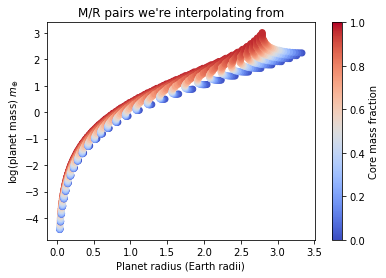

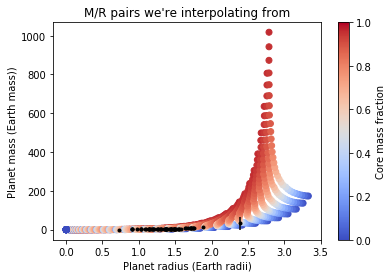

In [462]:
q = plt.figure()
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(planetrad.flatten(), np.log10(planetmass.flatten()), c = cmfarray.flatten(), vmin = 0., vmax = 1., cmap = cm)
#plt.plot(meanearthradii, np.log10(meanearthmasses),'k.')
#plt.errorbar(meanearthradii, np.log10(meanearthmasses),ls= 'none',yerr = np.log10(eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(planet mass) $m_{\oplus}$")
plt.title("M/R pairs we're interpolating from")
q.savefig("darkplot.jpg", bbox_inches = "tight")
plt.show()


cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(planetrad.flatten(), (planetmass.flatten()), c = cmfarray.flatten(), vmin = 0., vmax = 1., cmap = cm)
plt.plot(mean_planet_radii, (meanearthmasses),'k.')
plt.errorbar(mean_planet_radii, (meanearthmasses),ls= 'none',yerr = (eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.show()

In [463]:
kepid = []
koi = []
adivr = []
per = []
starrad = []
pradii = []
numstars = []


with open('USPHostProperties.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         if rownum > 0:
             kepid.append(int(row[0]))
             koi.append(int(row[1]))
             adivr.append(float(row[2]))
             per.append(float(row[3]))
             starrad.append(float(row[11]))
             pradii.append(float(row[12]))
             numstars.append(float(row[13]))
         rownum += 1

falsepositives = [4929299, 10527135, 5642620, 12170648, 3834322,6750902,7269881,10186945,12115188]

todelete = []
for j in range(0,len(falsepositives)):
    for i in range(0, len(kepid)):
        if kepid[i] == falsepositives[j]:
            todelete.append(i)
            
todelete.reverse()
for k in todelete:
    del kepid[k]
    del koi[k]
    del per[k]
    del adivr[k]
    del numstars[k]
    
adivr = [adivr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
per = [per[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
numstars = [numstars[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
print(len(per))
print(len(numstars))

62
62


In [464]:
len(numstars)

62

In [465]:
periodsamples = [per[i//1000] for i,j in enumerate(radiisamples)]

Okay, now we're going to do the occurrence rate and mass distribution calculations.

[ 1.44080454  0.2167958   0.28172701  0.11426947  0.63734558  0.91797049
  0.74362473  0.44249228  0.26401115  0.35243773  0.54816591  0.20680498
  0.14286687  0.45302447  1.01889784  0.81322662  0.34998748  0.95335732
  0.44931183  0.87788067  0.23237429  2.53582226  1.59732133  0.15983222
  0.92484168  0.31331454  0.23875905  0.27825623  0.14819117  1.04677295
  0.3165154   1.44981183  0.14596871 31.49312811  0.22412494  2.31723556
  0.17990173  0.05818252  0.34742949  0.69685075  0.03406118  0.85623843
  0.31163353  0.99776271  0.423676    0.63727087  0.45824974  0.85998692
  0.43883701  0.33497022  0.1748937   0.11773406  1.34870593  0.26689504
  1.09496722  0.24745808  0.46616517  0.12024381  0.25516913  0.82484651
  0.2738538   0.35270347]


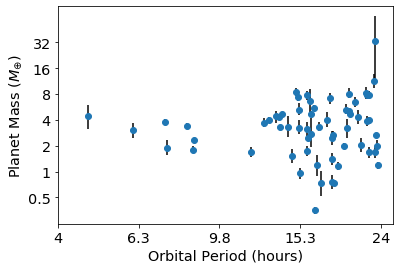

In [466]:
h = plt.figure()
#         meanearthmasses.append(np.percentile(list1, 50))
#         eartherr.append(np.std(list1))
#         eartherrup.append(np.percentile(list1, 15.85))
#         eartherrdown.append(np.percentile(list1, 84.15))
eartherrup = np.array(eartherrup)
eartherrdown = np.array(eartherrdown)
meanearthmasses= np.array(meanearthmasses)

print(eartherrdown - meanearthmasses)
plt.loglog(np.array(per) * 24,meanearthmasses, 'o', basex = (6**0.25), basey = np.sqrt(2))
plt.errorbar(np.array(per) * 24,meanearthmasses, yerr = [meanearthmasses - eartherrup, eartherrdown - meanearthmasses], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'x-large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'x-large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
h.savefig("PosterFig4.pdf", bbox_inches = "tight")
plt.show()

In [467]:
(meanearthmasses < 5).sum()

46

In [468]:
np.where(meanearthmasses > 30)

(array([33]),)

In [469]:
koi[33]

3106

## Radius distribution / Occurrence rates

In [470]:
import seaborn as sns

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
radbinsflip = np.flip(radbins,0) ## makes orientation correct on y axis

perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]
array = np.zeros((len(radbins)-1,len(perbins)-1))
scaledarray = np.zeros((len(radbins)-1,len(perbins)-1))
freqarray = np.zeros((len(radbins)-1,len(perbins)-1))

## calculates occurrence rate contribution for each planet sample
f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
kepid2 = []

In [471]:
persampleshours = [i * 24 for i in periodsamples]
contribs2 = [1/1000 for i,j in enumerate(radiisamples)]

def occur_freq_transit(masssamples, persampleshours, massbins, perbins):
    contribs = [(f[i//1000])/1000 for i,j in enumerate(masssamples)]
    contribs2 = [1/1000 for i,j in enumerate(masssamples)]
    occur = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)
    freq = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)
    transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
    transit = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                                       weights = transit_contribs)[0], 0)
    return occur, freq, transit

occur, freq, transit_array = occur_freq_transit(radiisamples, persampleshours, radbins, perbins)
# freq = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], weights = contribs2)[0], 0)
# #print(np.transpose(np.flip(freq, 1)))
print("Frequency array: \n", freq)

# ## we should divide the contributions by 1000, because 1000 samples per planet
# ## but then we just multiply by 1000 again because per 1000 stars
# contribs = [(f[i//1000])/1000 for i,j in enumerate(radiisamples)]
# occur = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], 
#                                weights = contribs)[0], 0)
print("Occurrence rate array: (per thousand stars) \n", occur * 1000)

# ## we divide transit contributions by 1000 because 1000 planets per star
# transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
# transit_array = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], 
#                                        weights = transit_contribs)[0], 0)
print("Transit array: \n", transit_array)

Frequency array: 
 [[0.0000e+00 0.0000e+00 0.0000e+00 6.5000e-02]
 [0.0000e+00 0.0000e+00 0.0000e+00 8.1100e-01]
 [8.6500e-01 9.4200e-01 7.9150e+00 1.7941e+01]
 [1.1350e+00 4.0520e+00 5.2820e+00 1.7575e+01]
 [0.0000e+00 6.0000e-03 8.0300e-01 4.4510e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.5700e-01]]
Occurrence rate array: (per thousand stars) 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.99593479e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.09024725e-02]
 [6.25738474e-02 2.45702821e-02 3.95504588e-01 1.13831399e+00]
 [5.97059132e-02 2.18699180e-01 3.43460800e-01 1.65014658e+00]
 [0.00000000e+00 7.08887491e-04 6.64501764e-02 1.11284176e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.18591716e-02]]
Transit array: 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.47905598e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.72177824e-05]
 [1.80715233e-05 9.50346824e-06 8.62291560e-05 2.33276810e-04]
 [1.65386685e-05 5.61959140e-05 7.76469443e-05 3.43701585e-04]
 [0.

We want to calculate the 68.3% Wilson confidence interval.

https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

In [472]:
z = 1
n = freq / transit_array

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [473]:
m = 500
pp = 421/500

z95 = 1.96
root = ((pp * (1-pp)) / m+ (z95**2)/(4*(m**2)))**0.5
denom = 1 + (z95**2)/m
high = (pp + (z95**2)/(2*m) + z95*root)/denom
low = (pp + (z95**2)/(2*m) - z95*root)/denom
print(high, low)


0.8713477936271825 0.8074369672976796


In [474]:
def occur_uncert(occur, numplanets, transit, z = 1):
    upper = np.zeros_like(occur)
    lower = np.zeros_like(occur)
    n = numplanets / transit
    for i in range(len(occur)):
        for j in range(len(occur[0])):
            if np.isnan(n[i][j]) == False:
                p = transit[i][j]

                root = (((p * (1-p)) / n[i][j]) + (z**2)/(4*(n[i][j]**2)))**0.5
                denom = 1 + (z**2)/n[i][j]
                high = (p + (z**2)/(2*n[i][j]) + z*root)/denom
                low = (p + (z**2)/(2*n[i][j]) - z*root)/denom
                upper[i][j] = (occur[i][j]/transit[i][j])*high * 1000 - (occur[i][j]/transit[i][j])*p * 1000
                lower[i][j] = (occur[i][j]/transit[i][j])*p * 1000 - (occur[i][j]/transit[i][j])*low * 1000
                #print(p * n[i][j])
    return upper, lower

In [475]:
upper, lower= occur_uncert(occur, freq, transit_array)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [476]:
print("upper: \n", upper)
print("value: \n", occur * 1000)
print("lower: \n", lower)

upper: 
 [[0.         0.         0.         0.11421917]
 [0.         0.         0.         0.15262656]
 [0.11255173 0.04151798 0.16775612 0.30228388]
 [0.08820753 0.13892577 0.18543851 0.44324532]
 [0.         0.11884999 0.12628867 0.66697594]
 [0.         0.         0.         0.37584963]]
value: 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.99593479e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.09024725e-02]
 [6.25738474e-02 2.45702821e-02 3.95504588e-01 1.13831399e+00]
 [5.97059132e-02 2.18699180e-01 3.43460800e-01 1.65014658e+00]
 [0.00000000e+00 7.08887491e-04 6.64501764e-02 1.11284176e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.18591716e-02]]
lower: 
 [[0.         0.         0.         0.00659217]
 [0.         0.         0.         0.05287567]
 [0.04021615 0.01543564 0.11779628 0.23886667]
 [0.03560571 0.08495944 0.1204248  0.34942   ]
 [0.         0.00070468 0.04354076 0.41706021]
 [0.         0.         0.         0.04557182]]


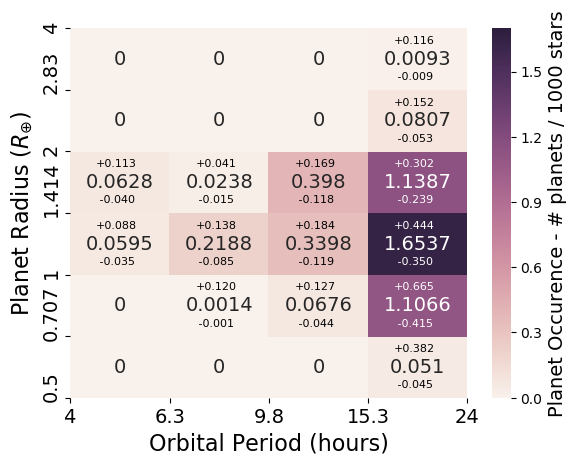

In [477]:
import matplotlib as mpl
mpl.style.use('default')

labels = np.array([[0,0,0,0.0093],[0,0,0,0.0807],[0.0628,0.0238,0.3980,1.1387],[0.0595,0.2188,0.3398,1.6537],[0,0.0014,0.0676,1.1066],[0,0,0,0.0510]],dtype = object)
fig, ax = plt.subplots()
ax = sns.heatmap(1000*occur, annot = labels, fmt = '', annot_kws={"size": 14}, vmin=0, vmax=1.7)
plt.text(3.26,5.75,"+0.116", size = 8)
plt.text(3.26,5.16," -0.009", size = 8)
plt.text(3.26,4.75,"+0.152", size = 8)
plt.text(3.26,4.16," -0.053", size = 8)
plt.text(0.26,3.75,"+0.113", size = 8)
plt.text(0.26,3.16," -0.040", size = 8)
plt.text(1.26,3.75,"+0.041", size = 8)
plt.text(1.26,3.16," -0.015", size = 8)
plt.text(2.26,3.75,"+0.169", size = 8)
plt.text(2.26,3.16," -0.118", size = 8)
plt.text(3.26,3.75,"+0.302", color = 'w', size = 8)
plt.text(3.26,3.16," -0.239", color = 'w', size = 8)
plt.text(0.26,2.75,"+0.088", size = 8)
plt.text(0.26,2.16," -0.035", size = 8)
plt.text(1.26,2.75,"+0.138", size = 8)
plt.text(1.26,2.16," -0.085", size = 8)
plt.text(2.26,2.75,"+0.184", size = 8)
plt.text(2.26,2.16," -0.119", size = 8)
plt.text(3.26,2.75,"+0.444", color = 'w', size = 8)
plt.text(3.26,2.16," -0.350", color = 'w', size = 8)
plt.text(1.26,1.75,"+0.120", size = 8)
plt.text(1.26,1.16," -0.001", size = 8)
plt.text(2.26,1.75,"+0.127", size = 8)
plt.text(2.26,1.16," -0.044", size = 8)
plt.text(3.26,1.75,"+0.665", color = 'w', size = 8)
plt.text(3.26,1.16," -0.415", color = 'w', size = 8)
plt.text(3.26,0.75,"+0.382", size = 8)
plt.text(3.26,0.16," -0.045", size = 8)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,0.707,1,1.414,2,2.83,4], fontsize = 14, horizontalalignment = 'right', verticalalignment = 'baseline')
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets / 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Radius ($R_{\oplus}$)", fontsize = 16)

fig.savefig("OccurrenceRates.pdf", bbox_inches='tight')
plt.show()


## Mass Distribution

In [478]:
massbins = [0.5,1,2,4,8,16,32]
massbins2 = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2) ## twice as many mass bins
massbinsflip = np.flip(massbins,0)

mass_occur_earth, mass_freq_earth, mass_transit_earth = occur_freq_transit(earthmasssamples, persampleshours, massbins, perbins)
mass_occur_earth2, mass_freq_earth2, mass_transit_earth2 = occur_freq_transit(earthmasssamples, persampleshours, massbins2, perbins)

mass_occur_merc, mass_freq_merc, mass_transit_merc = occur_freq_transit(mercurymasssamples, persampleshours, massbins, perbins)
mass_occur_merc2, mass_freq_merc2, mass_transit_merc2 = occur_freq_transit(mercurymasssamples, persampleshours, massbins2, perbins)

# ## we should divide the contributions by 1000, because 1000 samples per planet
# ## but then we just multiply by 1000 again because per 1000 stars
# contribs = [(f[i//1000])/1000 for i,j in enumerate(radiisamples)]
# contribs2 = [1/1000 for i,j in enumerate(radiisamples)]
# mass_occur_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], 
#                                weights = contribs)[0], 0)
# mass_occur_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], 
#                                weights = contribs)[0], 0)
# print("Occurrence rate array (Earth-like masses): (per thousand stars) \n", mass_occur_earth * 1000)

# mass_freq_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)
# mass_freq_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], weights = contribs2)[0], 0)

# print("Frequency (Earth-like masses): \n", mass_freq_earth)

# ## we divide transit contributions by 1000 because 1000 planets per star
# transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
# mass_transit_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_transit_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], 
#                                        weights = transit_contribs)[0], 0)
# print("Transit array: (Earth-like masses)\n", mass_transit_earth)

# mass_occur_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], 
#                                weights = contribs)[0], 0)
# mass_transit_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_freq_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)


# mass_occur_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], 
#                                weights = contribs)[0], 0)
# mass_transit_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_freq_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], weights = contribs2)[0], 0)

# a, b, c = occur_freq_transit(mercurymasssamples, persampleshours, massbins2, perbins)
# print(np.isclose(a, mass_occur_merc2))
# print(np.isclose(b, mass_freq_merc2))
# print(np.isclose(c, mass_transit_merc2))

In [479]:
mass_occur_earth_sum = np.flip((mass_occur_earth).sum(axis = 1))

(0, 50)

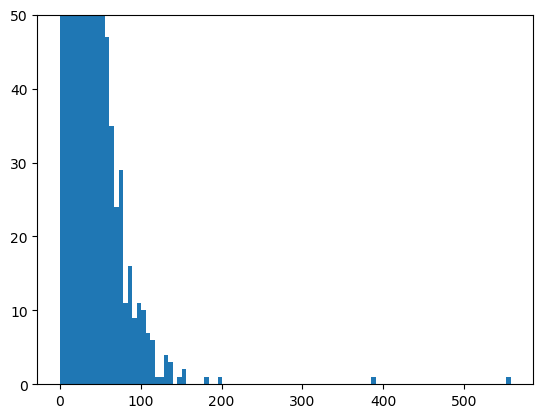

In [480]:
plt.hist(earthmasssamples, 100)
plt.ylim(0,50)

## Tidal distortion masses

In [481]:
short_period_indices = []
for i, j in enumerate([p * 24 for p in per]):
    if j < 10:
        short_period_indices.append(i)

In [482]:
M_star, star_mass_stdev = np.loadtxt("stellar_masses.txt")

In [483]:
np.savetxt("Short_period_logMs_per_rad.txt", np.column_stack(([np.log10(M_star[i]) for i in short_period_indices],
                                         [per[i] * 24 for i in short_period_indices],
                                         [mean_planet_radii[i] for i in short_period_indices])))


In [484]:
for i in short_period_indices:
    print(per[i]* 24, meanearthmasses[i])

4.736003999999999 4.484798244835805
8.52018072 2.337316043305282
6.06134256 3.0444162992024415
7.343613840000001 1.8938488988401314
7.2384208800000005 3.830657220577521
8.460393360000001 1.8071470272126173
8.204208 3.437513832437222


Hi, it's much later. I've now gotten the samples.

In [485]:
distort_earthlike_samples = np.loadtxt("earthlike_distorted_samples_081120.txt")
distort_earthlike_samples =  10**distort_earthlike_samples
print(len(distort_earthlike_samples))

7000


In [534]:
distort_earthlike_samples[::1000]

array([8.75259701, 2.56512146, 3.97949866, 2.51293864, 4.77400629,
       2.23947255, 3.73501987])

In [486]:
distort_earthlike_samples[:20]

array([ 8.75259701,  4.3316015 ,  8.61832574,  6.10050996,  6.16868422,
        5.912951  ,  5.42490536,  9.13033369, 11.06968246,  9.18887248,
        9.17453602,  8.24594623,  4.97720914,  5.95709406,  7.54366775,
       10.81390379,  8.98677371,  4.8812113 ,  5.3309157 ,  5.0441506 ])

In [487]:
import pandas as pd
df = pd.DataFrame()
spherical_samples = []
for index,value in enumerate(short_period_indices):
    spherical_samples.append(earthmasssamples[(1000*value) : (1000*(value+1))])
df['distorted_sample'] = distort_earthlike_samples
df['spherical_sample'] = np.array(spherical_samples).flatten()
periods = []
for i, j in enumerate(distort_earthlike_samples):
    periods.append(per[short_period_indices[i // 1000]])

In [488]:
len(periods)

7000

In [489]:
print(periods[999], periods[1001])

0.1973335 0.35500753


In [490]:
df['period'] = [round(i * 24, 2) for i in periods]

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Planet Mass ($M_{\\oplus}$)')

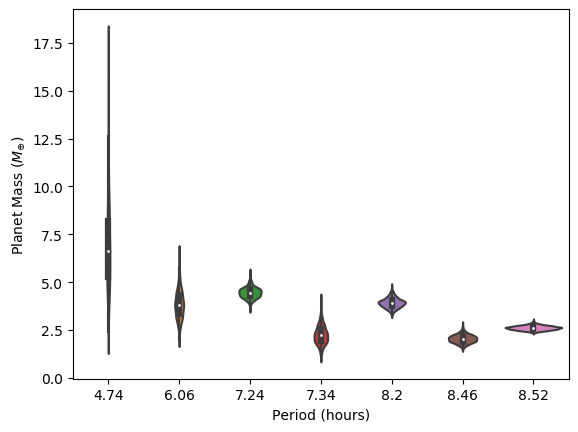

In [491]:
import seaborn as sns

sns.violinplot(x = df['period'], y= df['distorted_sample'])
plt.xlabel("Period (hours)")
plt.ylabel("Planet Mass ($M_{\oplus}$)")



/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])


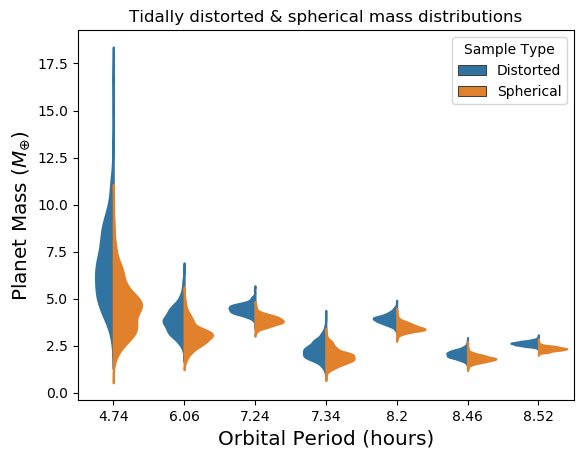

In [492]:
dumb_df = pd.DataFrame()
dumb_df['period'] = np.concatenate((df.period.values, df.period.values))
dumb_df['Sample Type'] = np.concatenate((['Distorted' for i in distort_earthlike_samples], ['Spherical' for i in df.spherical_sample.values]))
dumb_df['Sample'] = np.concatenate((distort_earthlike_samples, df.spherical_sample.values))
dumb_df['Log sample'] = np.log10(dumb_df.Sample.values)

d = plt.figure()
sns.violinplot(x = dumb_df['period'], y = dumb_df['Sample'], hue= dumb_df['Sample Type'], inner = None, split = True)
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{\oplus}$)", fontsize = 'x-large')
plt.title("Tidally distorted & spherical mass distributions")

plt.show()
d.savefig("DistortedDistributions.pdf", bbox_inches='tight')

In [493]:
distort_earth_masssamples = np.copy(earthmasssamples)

for index,value in enumerate(short_period_indices):
    print(index, value)
    for i, j in enumerate(distort_earth_masssamples[(1000*value) : (1000*(value+1))]):
        distort_earth_masssamples[(1000*value + i)] = distort_earthlike_samples[1000*index + i]
    

0 0
1 3
2 4
3 7
4 8
5 36
6 58


In [494]:
distort_earth_masssamples[3001]

2.468878398066451

(array([ 22., 104., 176., 205., 221., 160.,  74.,  27.,   9.,   2.]),
 array([2.35213398, 2.41965444, 2.4871749 , 2.55469537, 2.62221583,
        2.68973629, 2.75725676, 2.82477722, 2.89229768, 2.95981815,
        3.02733861]),
 <a list of 10 Patch objects>)

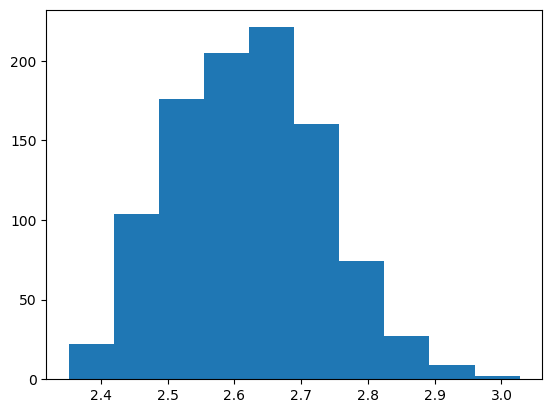

In [495]:
plt.hist(distort_earth_masssamples[3000:4000])

### Calculating uncertainties on earth-like mass distribution

In [496]:
upper_earth, lower_earth = occur_uncert(mass_occur_earth, mass_freq_earth, mass_transit_earth)

# upper_earth = np.zeros_like(mass_occur_earth)
# lower_earth = np.zeros_like(mass_occur_earth)
# n_earth = mass_freq_earth / mass_transit_earth
# for i in range(len(mass_occur_earth)):
#     for j in range(len(mass_occur_earth[0])):
#         if np.isnan(n_earth[i][j]) == False:
#             p = mass_transit_earth[i][j]
#             root = ( (p * (1-p)) / n_earth[i][j]) ** 0.5
#             high = p + z * root
#             low  = p - z * root
#             upper_earth[i][j] = (mass_occur_earth[i][j]/mass_transit_earth[i][j])*high * 1000 - (mass_occur_earth[i][j]/mass_transit_earth[i][j])*p * 1000
#             lower_earth[i][j] = (mass_occur_earth[i][j]/mass_transit_earth[i][j])*p * 1000 - (mass_occur_earth[i][j]/mass_transit_earth[i][j])*low * 1000

print("upper: \n", upper_earth)
print("actual: \n", mass_occur_earth * 1000)
print("lower: \n", lower_earth)

print(mass_occur_earth * 1000 - lower_earth)

upper: 
 [[0.         0.         0.         0.11970284]
 [0.08072425 0.         0.06823734 0.14151317]
 [0.10987877 0.03155149 0.14936112 0.26966676]
 [0.09261967 0.09869552 0.15808823 0.26237983]
 [0.05299181 0.12469191 0.1471563  0.43602726]
 [0.         0.11861604 0.11905472 0.54620706]]
actual: 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.80311003e-02]
 [1.50571224e-03 0.00000000e+00 3.96289244e-02 2.10719236e-01]
 [5.14804666e-02 7.23747698e-03 2.94291584e-01 8.43275718e-01]
 [6.72033337e-02 1.35221283e-01 2.58183082e-01 7.50048692e-01]
 [2.09024804e-03 1.01046998e-01 1.62110361e-01 1.06352626e+00]
 [0.00000000e+00 4.72591661e-04 5.12016122e-02 7.12419984e-01]]
lower: 
 [[0.         0.         0.         0.02271258]
 [0.00147814 0.         0.02506983 0.08466034]
 [0.03505636 0.00588708 0.09907898 0.20433467]
 [0.0389457  0.05705428 0.09805268 0.19439003]
 [0.00201093 0.05581629 0.07713745 0.30926181]
 [0.         0.00047072 0.03580395 0.30918224]]
[[0.00000000e+00 0.00000000

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Now I'm going to smush the grid into a 1d array, adding the errors in quadrature.

In [497]:
def smush_uncert(occur, upper, lower):
    occur_sum = np.flip((occur).sum(axis = 1))
    sum_upper = np.zeros_like(occur_sum)
    sum_lower = np.zeros_like(occur_sum)
    for i in range(len(occur)):
        errup = 0
        errdown = 0
        for j in upper[i]:
            errup += j**2
        for k in lower[i]:
            errdown += k**2
        sum_upper[i] = (errup**0.5)
        sum_lower[i] = (errdown**0.5)
    return occur_sum, sum_upper, sum_lower


mass_occur_earth_sum, mass_earth_sum_upper, mass_earth_sum_lower =  smush_uncert(mass_occur_earth, upper_earth, lower_earth)
print(mass_earth_sum_lower, mass_earth_sum_upper)

[0.02271258 0.08830659 0.2298541  0.22841579 0.3235932  0.31124877] [0.11970284 0.17663159 0.32878221 0.33489442 0.47971965 0.57147698]


In [498]:
# mass_occur_merc_sum = np.flip((mass_occur_merc).sum(axis = 1))

# upper_merc = np.zeros_like(mass_occur_merc)
# lower_merc = np.zeros_like(mass_occur_merc)
# n_merc = mass_freq_merc / mass_transit_merc
# for i in range(len(mass_occur_merc)):
#     for j in range(len(mass_occur_merc[0])):
#         if np.isnan(n_merc[i][j]) == False:
#             p = mass_transit_merc[i][j]
#             root = ((p * (1-p)) / n_merc[i][j] + (z**2)/(4*(n_merc[i][j]**2)))**0.5
#             denom = 1 + (z**2)/n_merc[i][j]
#             high = (p + (z**2)/(2*n_merc[i][j]) + z*root)/denom
#             low = (p + (z**2)/(2*n_merc[i][j]) - z*root)/denom
#             upper_merc[i][j] = 1000*(mass_occur_merc[i][j]/mass_transit_merc[i][j])*high - 1000*mass_occur_merc[i][j]
#             lower_merc[i][j] = 1000*mass_occur_merc[i][j] - 1000*(mass_occur_merc[i][j]/mass_transit_merc[i][j])*low
            
            
# print("upper: \n", upper_merc)
# #print("lower: \n", lower_merc)


upper_merc, lower_merc = occur_uncert(mass_occur_merc, mass_freq_merc, mass_transit_merc)



# mass_merc_sum_upper = np.zeros_like(mass_occur_merc_sum)
# mass_merc_sum_lower = np.zeros_like(mass_occur_merc_sum)

# for i in range(len(n_merc)):
#     errup = 0
#     errdown = 0
#     for j in upper_merc[i]:
#         errup += j**2
#     for k in lower_merc[i]:
#         errdown += k**2
#     mass_merc_sum_upper[i] = (errup**0.5)
#     mass_merc_sum_lower[i] = (errdown**0.5)
    
    
mass_occur_merc_sum, mass_merc_sum_upper, mass_merc_sum_lower  =  smush_uncert(mass_occur_merc, upper_merc, lower_merc)
# print(mass_merc_sum_lower, mass_merc_sum_upper)
# print(np.isclose(mu, mass_merc_sum_upper))
# print(np.isclose(ml, mass_merc_sum_lower))
# print(ml)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


## Mass Distribution Graph

In [499]:
np.shape(rand_array)

(50, 62000)

In [500]:
rand_array = []
for i in range(0, 50):
    
    randmasses = []
    print(i)
    for j, radsample in enumerate(radiisamples): 
        if j % 1000 == 0: ## use a different CMF for each planet
            randomcmf = np.random.normal(0.33,0.1)
            while (randomcmf <= 0):
                randomcmf = np.random.normal(0.33,0.1)
        try:
            randmasses.append(get_mass(radsample, randomcmf))
        except:
            #print("could not interpolate for sample", j, "cmf = ", randomcmf)
            randmasses.append(np.nan)
#     plt.hist(randmasses)
#     plt.show()
            
    rand_array.append(randmasses)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [501]:
#np.shape(rand_array)

In [502]:
contribs = [(f[i//1000])/1000 for i,j in enumerate(radiisamples)]

In [503]:
def plot_mass_dist(massbins):
    
    mass_occur_earth, mass_freq_earth, mass_transit_earth = occur_freq_transit(earthmasssamples, persampleshours, massbins, perbins)

    mass_occur_merc, mass_freq_merc, mass_transit_merc = occur_freq_transit(mercurymasssamples, persampleshours, massbins, perbins)

    upper_earth, lower_earth = occur_uncert(mass_occur_earth, mass_freq_earth, mass_transit_earth)
    mass_occur_earth_sum, mass_earth_sum_upper, mass_earth_sum_lower =  smush_uncert(mass_occur_earth, upper_earth, lower_earth)

    upper_merc, lower_merc = occur_uncert(mass_occur_merc, mass_freq_merc, mass_transit_merc)
    mass_occur_merc_sum, mass_merc_sum_upper, mass_merc_sum_lower  =  smush_uncert(mass_occur_merc, upper_merc, lower_merc)
    
    ## adding tidally distorted masses
    mass_occur_distort, mass_freq_distort, mass_transit_distort = occur_freq_transit(distort_earth_masssamples, persampleshours, massbins, perbins)
    
    upper_distort, lower_distort = occur_uncert(mass_occur_distort, mass_freq_distort, mass_transit_distort)
    mass_occur_distort_sum, mass_distort_sum_upper, mass_distort_sum_lower =  smush_uncert(mass_occur_distort, upper_distort, lower_distort)


    massticks = np.zeros(len(massbins)-1) 
    for i in range(len(massbins)-1):
        massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)


    for i, j in enumerate(rand_array):
        
        mass_occur_rand = np.flip(np.histogram2d(j, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)

        mass_occur_rand_sum = np.flip((mass_occur_rand).sum(axis = 1))
        plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g')
    plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g', label = 'Random composition')
    plt.plot(massticks,mass_occur_earth_sum * 1000, label = 'Earth-like', linewidth = 2.5, color = 'tab:blue')
    plt.plot(massticks,mass_occur_merc_sum * 1000, label = 'Mercury-like', linewidth = 2.5, color = 'tab:orange')
    plt.plot(massticks,mass_occur_distort_sum * 1000, label = 'With Earth-like distorted planets', linewidth = 2.5, color = 'tab:red')
#     plt.errorbar(massticks,mass_occur_earth_sum * 1000, yerr = np.stack((mass_earth_sum_lower,mass_earth_sum_upper)), linestyle = 'None', ecolor = 'tab:blue', capsize = 6)
#     plt.errorbar(massticks,mass_occur_merc_sum * 1000, yerr = np.stack((mass_merc_sum_lower,mass_merc_sum_upper)), linestyle = 'None', ecolor = 'tab:orange', capsize = 6)
    plt.fill_between(massticks, mass_occur_earth_sum * 1000 + mass_earth_sum_upper,  mass_occur_earth_sum * 1000 - mass_earth_sum_lower, alpha = 0.2)
    plt.fill_between(massticks, mass_occur_merc_sum * 1000 + mass_merc_sum_upper,  mass_occur_merc_sum * 1000 - mass_merc_sum_lower, alpha = 0.2)
    
    plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32], fontsize = 'x-large')
    plt.xlabel('Planet Mass ($M_{ \oplus}$)', fontsize = 'x-large')
    plt.ylabel('Number of planets per thousand stars', fontsize = 'x-large')
    plt.ylim(0, 1.75)
    plt.legend()
    plt.show()

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


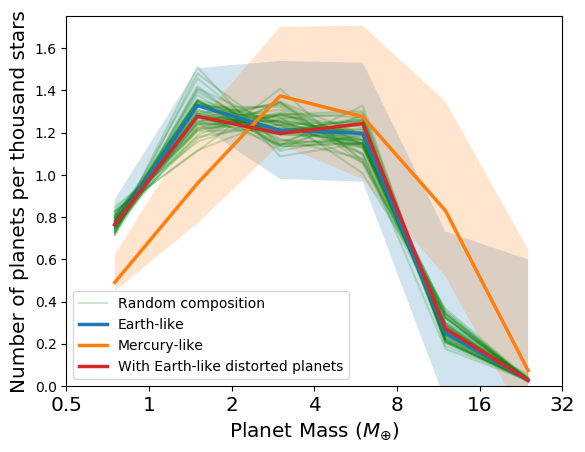

In [504]:
plot_mass_dist(massbins)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


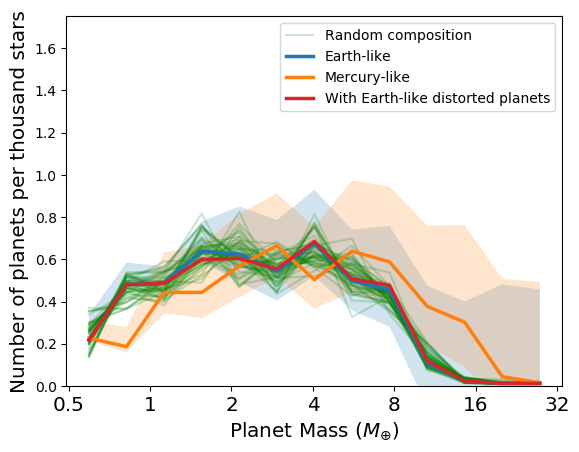

In [505]:
plot_mass_dist(massbins2)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


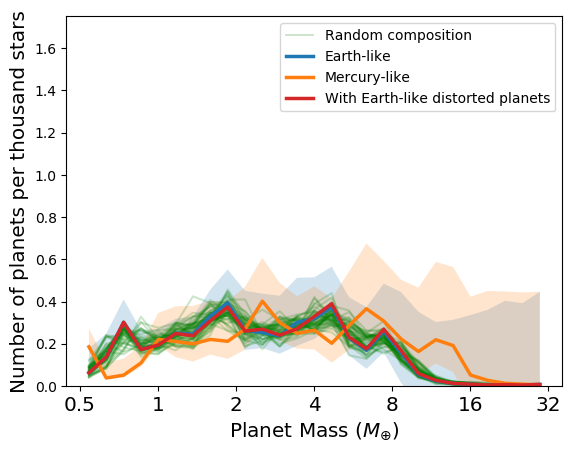

In [506]:
plot_mass_dist(np.logspace(np.log2(0.5), np.log2(32), 28, base = 2))

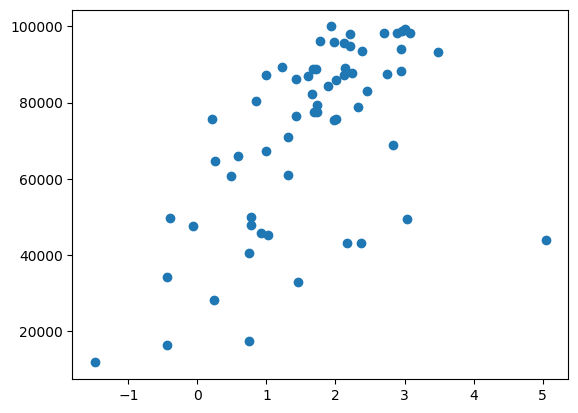

In [507]:
plt.plot(np.log2(meanearthmasses), numstars, 'o')


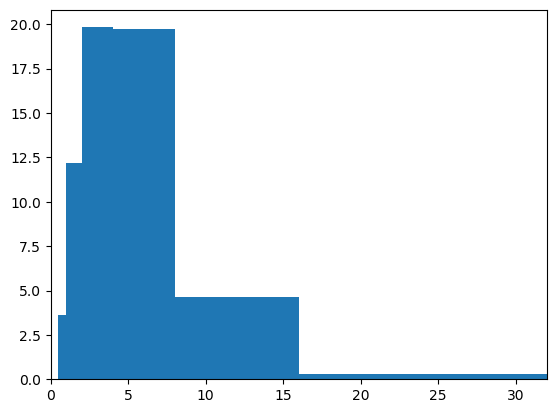

In [508]:
plt.hist(earthmasssamples, bins = massbins, weights = contribs2)
plt.xlim(0,32)
plt.show()

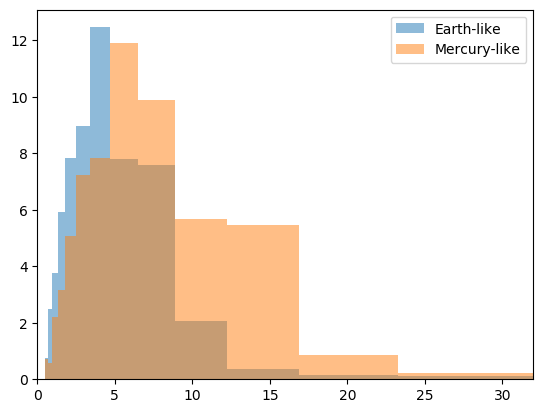

In [509]:
plt.hist(earthmasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2), weights = contribs2, alpha = 0.5, label = "Earth-like")
plt.hist(mercurymasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2), weights = contribs2,  alpha = 0.5, label = "Mercury-like")
plt.legend()
plt.xlim(0,32)
plt.show()

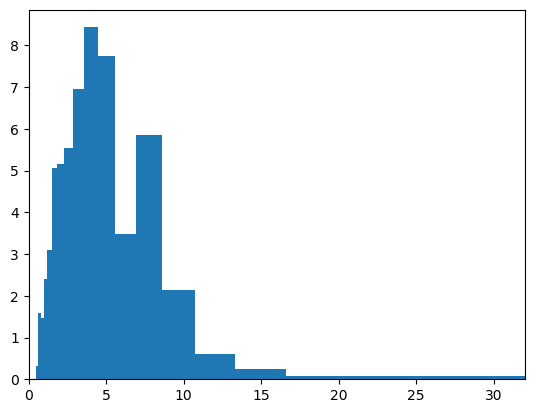

In [510]:
plt.hist(earthmasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 20, base = 2), weights = contribs2)
plt.xlim(0,32)
plt.show()

## Incorporating Measured Masses

I'm going to incorporate measured masses for Kepler-10b and Kepler-78b. For Kepler-10b, the measured mass is 3.72 +/- 0.42 Earth masses. For Kepler-78b, the measured mass is 1.82 +/- 0.27 

Kepler-78b mass: https://ui.adsabs.harvard.edu/abs/2015ESS.....311305G/abstract

Kepler-10b mass: https://arxiv.org/abs/1601.06168

In [511]:
list(kepids).index(11600889)

50

(array([  7.,  51.,  95., 185., 202., 217., 142.,  71.,  28.,   2.]),
 array([1.95574439, 2.06265854, 2.16957269, 2.27648684, 2.38340099,
        2.49031514, 2.59722929, 2.70414344, 2.81105759, 2.91797174,
        3.02488589]),
 <a list of 10 Patch objects>)

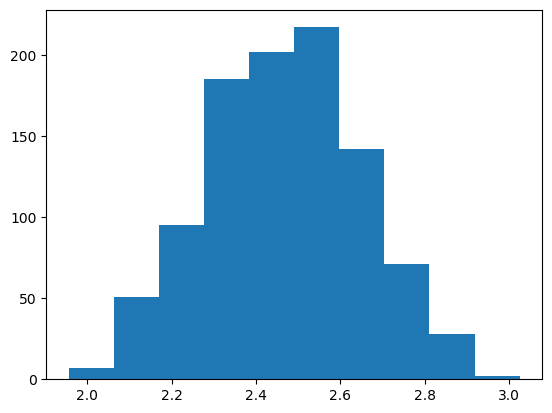

In [512]:
plt.hist(earthmasssamples[50000:51000])

In [513]:
import scipy.stats
dist10 = scipy.stats.norm(3.72, 0.42)
dist78 = scipy.stats.norm(1.77, 0.25)

In [514]:
list(kepids).index(11904151) ## Kepler-10

53

In [515]:
f[53]

4.4267719107089625e-05

In [516]:
list(kepids).index(8435766) ## Kepler-78

3

In [517]:
f[3]

3.76827631638806e-05

In [518]:
len(radiisamples)

62000

In [519]:
kep10_earthsamples = earthmasssamples[53 * 1000: 54 * 1000]
kep78_earthsamples = earthmasssamples[3 * 1000: 4 * 1000]
kep10_mercsamples = mercurymasssamples[53 * 1000: 54 * 1000]
kep78_mercsamples = mercurymasssamples[3 * 1000: 4 * 1000]

We are calculating a normalization factor as follows:
$ n = \frac{\sum{f}}{\sum{f * pdf(m)}}$

where f is the occurrence rate contribution and pdf(m) is the probability of getting that mass.

In [520]:
print("Kepler-10 measured mass: 3.72 +/- 0.42")
print(np.average(kep10_earthsamples), np.std(kep10_earthsamples))
print(np.average(kep10_mercsamples), np.std(kep10_mercsamples))


print("Kepler-78b measured mass: 1.77 +/- 0.25")
print(np.average(kep78_earthsamples), np.std(kep78_earthsamples))

Kepler-10 measured mass: 3.72 +/- 0.42
5.029758464562179 0.2945064101369074
7.922713010982252 0.547760223677926
Kepler-78b measured mass: 1.77 +/- 0.25
2.3372309290538196 0.11135975167354063


In [521]:
kep10_radiisamples = radiisamples[53 * 1000: 54 * 1000]
kep78_radiisamples = radiisamples[3 * 1000: 4 * 1000]

print("Kepler-10 measured radius: 1.47")
print(np.average(kep10_radiisamples), np.std(kep10_radiisamples))

print("Kepler-10 measured radius: 1.2")
print(np.average(kep78_radiisamples), np.std(kep78_radiisamples))

Kepler-10 measured radius: 1.47
1.5368721104787384 0.025448109946462176
Kepler-10 measured radius: 1.2
1.2505467573684559 0.014647018712664415


(array([ 13., 104., 174., 269., 234., 154.,  41.,   9.,   1.,   1.]),
 array([2.04012365, 2.11829454, 2.19646543, 2.27463633, 2.35280722,
        2.43097811, 2.509149  , 2.5873199 , 2.66549079, 2.74366168,
        2.82183257]),
 <a list of 10 Patch objects>)

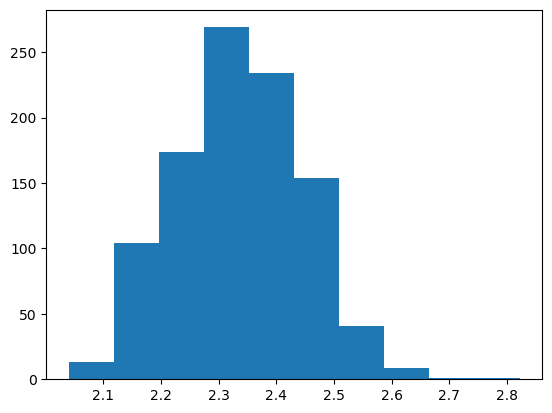

In [522]:
plt.hist(kep78_earthsamples)

In [523]:
sum_contribs_10 = 0
sum_contribs_78 = 0
sum_weighted_10 = 0
sum_weighted_78 = 0
for i,j in zip(kep10_earthsamples, kep78_earthsamples):
    sum_contribs_10 += f[53]
    sum_contribs_78 += f[3]
    sum_weighted_10 += f[53]*dist10.pdf(i)
    sum_weighted_78 += f[3]*dist78.pdf(j)

earth10norm = sum_contribs_10 / sum_weighted_10
earth78norm = sum_contribs_78 / sum_weighted_78
print(earth10norm, earth78norm)    
    

34.144617091819015 5.894621487412204


In [524]:
sum_contribs_10 = 0
sum_contribs_78 = 0
sum_weighted_10 = 0
sum_weighted_78 = 0
for i,j in zip(kep10_mercsamples, kep78_mercsamples):
    sum_contribs_10 += f[53]
    sum_contribs_78 += f[3]
    sum_weighted_10 += f[53]*dist10.pdf(i)
    sum_weighted_78 += f[3]*dist78.pdf(j)

merc10norm = sum_contribs_10 / sum_weighted_10
merc78norm = sum_contribs_78 / sum_weighted_78
    
print(merc10norm, merc78norm)  

172806851928.85114 253711672.4893469


Now, I will re-calculate the ocurrence rates in the mass bins, but the occurrence rate contribution for each mass sample will be: $f * n * pdf(m)$

In [525]:
f[3]

3.76827631638806e-05

In [526]:
f[3] * dist78.pdf(earthmasssamples[3100]) * earth78norm

1.4483501214858412e-05

In [527]:
contribs = [(f[i//1000])/1000 for i,j in enumerate(earthmasssamples)]
earth_measured_contribs = np.copy(contribs)
for i, j in enumerate(contribs[(1000*3) : (1000*(4))]):
    if i % 100 == 0:
        print(earth_measured_contribs[(1000*3 + i)])
    earth_measured_contribs[(1000*3 + i)] = f[3] / 1000 * dist78.pdf(earthmasssamples[(1000*3 + i)]) * earth78norm
    if i % 100 == 0:
        print(earth_measured_contribs[(1000*3 + i)])
for i, j in enumerate(contribs[(1000*53) : (1000*(54))]):
    earth_measured_contribs[(1000*53 + i)] = f[53] / 1000 * dist10.pdf(earthmasssamples[(1000*53 + i)]) * earth10norm

merc_measured_contribs = np.copy(contribs)
for i, j in enumerate(contribs[(1000*3) : (1000*(4))]):
    merc_measured_contribs[(1000*3 + i)] = f[3] / 1000 * dist78.pdf(mercurymasssamples[(1000*3 + i)]) * merc78norm
for i, j in enumerate(contribs[(1000*53) : (1000*(54))]):
    merc_measured_contribs[(1000*53 + i)] = f[53] / 1000 * dist10.pdf(mercurymasssamples[(1000*53 + i)]) * merc10norm
    

def occur_freq_transit_measured(contribs, masssamples, persampleshours, massbins, perbins):

    contribs2 = [1/1000 for i,j in enumerate(masssamples)]
    occur = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)
    freq = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)
    transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
    transit = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                                       weights = transit_contribs)[0], 0)
    return occur, freq, transit

3.7682763163880594e-08
1.3997665413612569e-08
3.7682763163880594e-08
1.4483501214858413e-08
3.7682763163880594e-08
5.347080358228655e-08
3.7682763163880594e-08
7.498007614304413e-08
3.7682763163880594e-08
3.089531755084969e-08
3.7682763163880594e-08
1.1003217153009642e-07
3.7682763163880594e-08
7.590719429973771e-09
3.7682763163880594e-08
7.746205696452388e-09
3.7682763163880594e-08
2.0816164355038272e-08
3.7682763163880594e-08
4.428169174269123e-08


In [528]:
kep10_samples = np.random.normal(3.72, 0.42, 1000)
kep78_samples = np.random.normal(1.77, 0.25, 1000)

In [529]:
measured_samples_no_weighting_earth = np.copy(earthmasssamples)
measured_samples_no_weighting_earth[53 * 1000: 54 * 1000] = kep10_samples
measured_samples_no_weighting_earth[3 * 1000: 4 * 1000] = kep78_samples

measured_samples_no_weighting_merc = np.copy(mercurymasssamples)
measured_samples_no_weighting_merc[53 * 1000: 54 * 1000] = kep10_samples
measured_samples_no_weighting_merc[3 * 1000: 4 * 1000] = kep78_samples

In [530]:
def get_graph_arrays(masssamples, persamples = persampleshours, massbins = massbins, perbins = perbins):
    mass_occur, mass_freq, mass_transit = occur_freq_transit(masssamples, persamples, massbins, perbins)
    upper, lower = occur_uncert(mass_occur, mass_freq, mass_transit)
    mass_occur_sum, mass_sum_upper, mass_sum_lower =  smush_uncert(mass_occur, upper, lower)
    return mass_occur_sum, mass_sum_upper, mass_sum_lower

In [531]:
def get_graph_arrays_measured(contribs, masssamples, persamples = persampleshours, massbins = massbins, perbins = perbins):
    mass_occur, mass_freq, mass_transit = occur_freq_transit_measured(contribs, masssamples, persamples, massbins, perbins)
    upper, lower = occur_uncert(mass_occur, mass_freq, mass_transit)
    mass_occur_sum, mass_sum_upper, mass_sum_lower =  smush_uncert(mass_occur, upper, lower)
    return mass_occur_sum, mass_sum_upper, mass_sum_lower

In [532]:
def plot_mass_dist_w_measured(massbins):

    mass_occur_earth_sum, mass_earth_sum_upper, mass_earth_sum_lower =  get_graph_arrays(earthmasssamples)
    mass_occur_merc_sum, mass_merc_sum_upper, mass_merc_sum_lower  =  get_graph_arrays(mercurymasssamples)
    
    ## adding measured masses
    ## weighting mass samples according to measured masses
    mass_occur_e_measure_sum, mass_e_measure_sum_upper, mass_e_measure_sum_lower =  get_graph_arrays_measured(earth_measured_contribs, earthmasssamples)
    mass_occur_m_measure_sum, mass_m_measure_sum_upper, mass_m_measure_sum_lower =  get_graph_arrays_measured(merc_measured_contribs, mercurymasssamples)
    
    ## replacing mass samples with samples from measured distribution
    mass_measure_sum_e, mass_measure_sum_e_upper, mass_measure_sum_e_lower = get_graph_arrays(measured_samples_no_weighting_earth)
    mass_measure_sum_m, mass_measure_sum_e_upper, mass_measure_sum_m_lower = get_graph_arrays(measured_samples_no_weighting_merc)


    ## adding tidally distorted masses
    mass_occur_distort_sum, mass_distort_sum_upper, mass_distort_sum_lower =  get_graph_arrays(distort_earth_masssamples)


    massticks = np.zeros(len(massbins)-1) 
    for i in range(len(massbins)-1):
        massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)

    ## plot random mass distributions
    for i, j in enumerate(rand_array):
        mass_occur_rand = np.flip(np.histogram2d(j, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)

        mass_occur_rand_sum = np.flip((mass_occur_rand).sum(axis = 1))
        plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g')
    plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g', label = 'Random composition')
    
    ## plot measured masses
    plt.plot(massticks,mass_measure_sum_m * 1000, linewidth = 2.5, color = 'tab:orange', linestyle='dashed')
    plt.plot(massticks,mass_measure_sum_e * 1000, linewidth = 2.5, color = 'tab:blue', linestyle='dashed')

    ## plot other distributions
    plt.plot(massticks,mass_occur_earth_sum * 1000, label = 'Earth-like', linewidth = 2.5, color = 'tab:blue')
    plt.plot(massticks,mass_occur_merc_sum * 1000, label = 'Mercury-like', linewidth = 2.5, color = 'tab:orange')
    plt.plot(massticks,mass_occur_distort_sum * 1000, label = 'With Earth-like distorted planets', linewidth = 2.5, color = 'tab:red')

    ## plot fake gray dashed line just to get it on the legend
    plt.plot(massticks, -1 * np.ones_like(mass_measure_sum_e), label = 'Incorporating measured masses', linewidth = 2.5, color = 'tab:gray', linestyle='dashed')
    
    ## error shading
    plt.fill_between(massticks, mass_occur_earth_sum * 1000 + mass_earth_sum_upper,  mass_occur_earth_sum * 1000 - mass_earth_sum_lower, alpha = 0.2)
    plt.fill_between(massticks, mass_occur_merc_sum * 1000 + mass_merc_sum_upper,  mass_occur_merc_sum * 1000 - mass_merc_sum_lower, alpha = 0.2)
    
    plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32], fontsize = 'x-large')
    plt.xlabel('Planet Mass ($M_{ \oplus}$)', fontsize = 'x-large')
    plt.ylabel('Number of planets per thousand stars', fontsize = 'x-large')
    plt.ylim(0, 1.75)
    plt.legend(loc = 'lower left')
    plt.show()

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


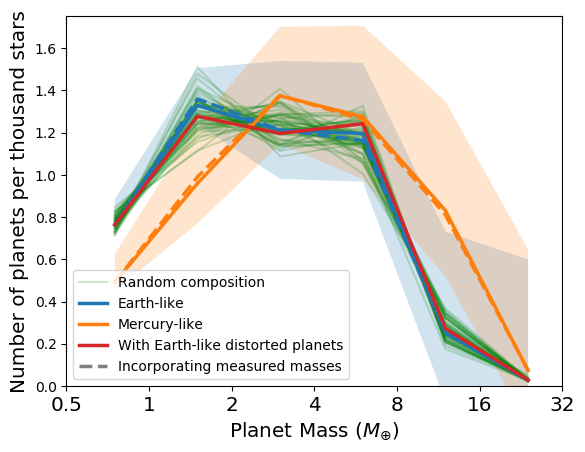

In [533]:
q = plt.figure()
plot_mass_dist_w_measured(massbins)

q.savefig("MassDistributionFinal.pdf", bbox_inches='tight')